# Modelling Using Term Frequency - Inverse Document Frequency

In [42]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

## Data Processing
Before we can begin creating models to predict peoples scores we have to ensure that the data is cleaned and interpretable.
As our dataset has a major class imbalance, where majority of people score an average mark of 4 and very few score a maximum of 8 or minimum of 1 or 2 marks we oversample the lower classes.
We additionally remove the automated mentor messages which have been given an average mark.

In [2]:
df = pd.read_csv("../data/data.csv")
df = df[df["RoleName"] != "Mentor"]

In [3]:
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(df[["content"]], df["OutcomeScore"])
x_train, x_test, y_train, y_test = train_test_split(x_resampled["content"], y_resampled, train_size=0.8, random_state=0)
_, x_test, _, y_test = train_test_split(df["content"], df["OutcomeScore"], train_size=0.8, random_state=0) # test on imbalanced data

## Model Training
Models require us to re-represent our worded language data in a numeric format.
To do so we can use the built in TF-IDF (Term Frequency - Inverse Document Frequency) models.
This works by first calculating the number of times each word is used in total and in every seperate document.
This can be divided and used as numeric data in future models like random forests and logistic regression.


We will prioritise testing two types of models:
* Random Forests - An Ensemble of Decision Trees
* Logistic Regression

To simplify the creation and usage of these models we will compose several pipelines.
Each of these will start with a TF-IDF vectoriser (to transform the text into a matrix of numbers) and after this proceed with a classifier (like logistic regression).

In [4]:
baseline_clf = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=0, max_iter=500))
baseline_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=0))])

In [37]:
naive_bayes_clf = make_pipeline(TfidfVectorizer(), MultinomialNB())
naive_bayes_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [43]:
k_nearest_neighbors_clf = make_pipeline(TfidfVectorizer(), KNeighborsClassifier())
k_nearest_neighbors_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [47]:
decision_tree_clf = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier(random_state=0))
decision_tree_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=0))])

In [5]:
random_forest_clf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=0))
random_forest_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [6]:
gradient_boosted_clf = make_pipeline(TfidfVectorizer(), GradientBoostingClassifier(n_estimators=300, random_state=0))
gradient_boosted_clf.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=300, random_state=0))])

## Evaluation
To evaluate how good our models are we will start by formulating a baseline estimate of how good a basic logistic regression model performs.
We will look at the F1 score (which weighs precision and recall) and plot the confusion matrix.
This will be repeated for each additional model.

In [7]:
def evaluate_model(model_pipeline):
    predictions = model_pipeline.predict(x_test)
    f1 = f1_score(y_test, predictions, average="weighted")
    report = classification_report(y_test, predictions)
    
    plot_confusion_matrix(model_pipeline, x_test, y_test);
    
    return f1, report

## Logistic Regression Baseline

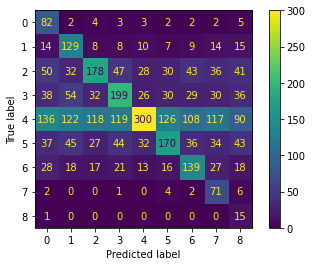

In [26]:
f1, report = evaluate_model(baseline_clf)

In [27]:
f1

0.39067423458176936

In [28]:
print(report)

              precision    recall  f1-score   support

           0       0.21      0.78      0.33       105
           1       0.32      0.60      0.42       214
           2       0.46      0.37      0.41       485
           3       0.45      0.42      0.43       474
           4       0.73      0.24      0.36      1236
           5       0.44      0.36      0.40       468
           6       0.38      0.47      0.42       297
           7       0.21      0.83      0.34        86
           8       0.06      0.94      0.11        16

    accuracy                           0.38      3381
   macro avg       0.36      0.56      0.36      3381
weighted avg       0.52      0.38      0.39      3381



## Naive Bayes

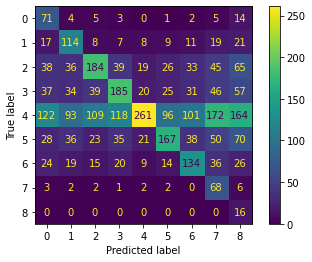

In [38]:
f1, report = evaluate_model(naive_bayes_clf)

In [39]:
f1

0.3771289927277267

In [41]:
print(report)

              precision    recall  f1-score   support

           0       0.21      0.68      0.32       105
           1       0.34      0.53      0.41       214
           2       0.48      0.38      0.42       485
           3       0.45      0.39      0.42       474
           4       0.77      0.21      0.33      1236
           5       0.49      0.36      0.41       468
           6       0.38      0.45      0.41       297
           7       0.15      0.79      0.26        86
           8       0.04      1.00      0.07        16

    accuracy                           0.35      3381
   macro avg       0.37      0.53      0.34      3381
weighted avg       0.55      0.35      0.38      3381



## K-Nearest Neighbors

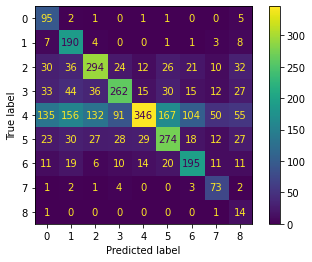

In [44]:
f1, report = evaluate_model(k_nearest_neighbors_clf)

In [45]:
f1

0.5132421597351163

In [46]:
print(report)

              precision    recall  f1-score   support

           0       0.28      0.90      0.43       105
           1       0.40      0.89      0.55       214
           2       0.59      0.61      0.60       485
           3       0.63      0.55      0.59       474
           4       0.83      0.28      0.42      1236
           5       0.53      0.59      0.56       468
           6       0.55      0.66      0.60       297
           7       0.42      0.85      0.57        86
           8       0.08      0.88      0.14        16

    accuracy                           0.52      3381
   macro avg       0.48      0.69      0.49      3381
weighted avg       0.64      0.52      0.51      3381



## Decision Trees

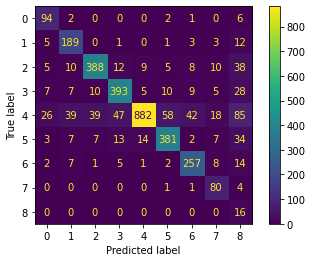

In [48]:
f1, report = evaluate_model(decision_tree_clf)

In [49]:
f1

0.816505933423398

In [50]:
print(report)

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       105
           1       0.72      0.88      0.80       214
           2       0.87      0.80      0.83       485
           3       0.83      0.83      0.83       474
           4       0.97      0.71      0.82      1236
           5       0.83      0.81      0.82       468
           6       0.80      0.87      0.83       297
           7       0.61      0.93      0.74        86
           8       0.07      1.00      0.13        16

    accuracy                           0.79      3381
   macro avg       0.71      0.86      0.73      3381
weighted avg       0.86      0.79      0.82      3381



## Random Forests

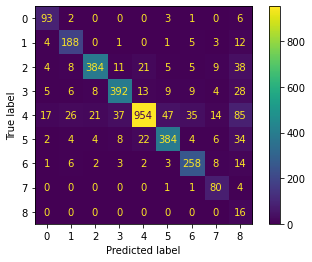

In [29]:
f1, report = evaluate_model(random_forest_clf)

In [30]:
f1

0.8373794281635332

In [31]:
print(report)

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       105
           1       0.78      0.88      0.83       214
           2       0.92      0.79      0.85       485
           3       0.87      0.83      0.85       474
           4       0.94      0.77      0.85      1236
           5       0.85      0.82      0.83       468
           6       0.81      0.87      0.84       297
           7       0.65      0.93      0.76        86
           8       0.07      1.00      0.13        16

    accuracy                           0.81      3381
   macro avg       0.74      0.86      0.75      3381
weighted avg       0.88      0.81      0.84      3381



## Gradient Boosting

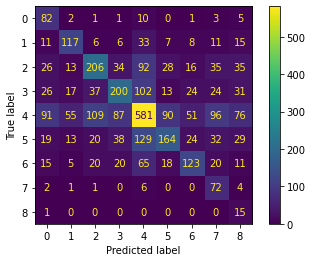

In [32]:
f1, report = evaluate_model(gradient_boosted_clf)

In [33]:
f1

0.47542054832350045

In [34]:
print(report)

              precision    recall  f1-score   support

           0       0.30      0.78      0.43       105
           1       0.52      0.55      0.54       214
           2       0.52      0.42      0.47       485
           3       0.52      0.42      0.47       474
           4       0.57      0.47      0.52      1236
           5       0.51      0.35      0.42       468
           6       0.50      0.41      0.45       297
           7       0.25      0.84      0.38        86
           8       0.07      0.94      0.13        16

    accuracy                           0.46      3381
   macro avg       0.42      0.58      0.42      3381
weighted avg       0.52      0.46      0.48      3381

